In [1]:
import struct
print( 8 * struct.calcsize("P"))

64


In [1]:
import dask.bag as db
import dask.dataframe as dd
import pandas as pd
import json
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import re
from collections import defaultdict
from os import path
from wordcloud import WordCloud
from pylab import rcParams
import numpy as np

import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

# Set iPython to display visualization inline
%matplotlib inline

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# read the entire file into a python array
with open('Data/yelp_academic_dataset_review.json', 'rb') as f:
   data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip().decode("utf-8"), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
#print(data[0])
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df_review = pd.read_json(data_json_str)

df_review.head(5)


,business_id,date,review_id,stars,text,type,user_id,votes
0,5UmKMjUEUNdYWqANhGckJw,2012-08-01,Ya85v4eqdd6k9Od8HbQjyA,4,"Mr Hoagie is an institution. Walking in, it do...",review,PUFPaY9KxDAcGqfsorJp3Q,"{'funny': 0, 'useful': 0, 'cool': 0}"
1,5UmKMjUEUNdYWqANhGckJw,2014-02-13,KPvLNJ21_4wbYNctrOwWdQ,5,Excellent food. Superb customer service. I mis...,review,Iu6AxdBYGR4A0wspR9BYHA,"{'funny': 0, 'useful': 0, 'cool': 0}"
2,5UmKMjUEUNdYWqANhGckJw,2015-10-31,fFSoGV46Yxuwbr3fHNuZig,5,Yes this place is a little out dated and not o...,review,auESFwWvW42h6alXgFxAXQ,"{'funny': 0, 'useful': 0, 'cool': 0}"
3,UsFtqoBl7naz8AVUBZMjQQ,2013-11-08,Di3exaUCFNw1V4kSNW5pgA,5,All the food is great here. But the best thing...,review,uK8tzraOp4M5u3uYrqIBXg,"{'funny': 0, 'useful': 0, 'cool': 0}"
4,UsFtqoBl7naz8AVUBZMjQQ,2014-03-29,0Lua2-PbqEQMjD9r89-asw,3,We checked this place out this past Monday for...,review,I_47G-R2_egp7ME5u_ltew,"{'funny': 0, 'useful': 0, 'cool': 0}"


In [3]:
def dichotomize(row):
    if row["stars"] >= 3:
        return 'good'
    else:
        return 'bad'
    
df_review = df_review.loc[df_review['date'].dt.year == 2015]
df_review = df_review.sample(n=400000)
df_review = df_review[["stars", "text"]]
df_review['dichotomy'] = df_review.apply(lambda row: dichotomize(row), axis=1)
df_review.head(5)

,stars,text,dichotomy
255370,5,"After struggling with melasma for years, I fin...",good
1509018,2,I was looking forward to my experience at Leo'...,bad
982311,5,Great selection and amazing customer service! ...,good
404987,5,one of the best experiences in las vegas that ...,good
1328463,4,ONLY reason why I'm giving 4 stars it's becaus...,good


In [4]:
Stars = [1,2,3,4,5]

#[^a-zA-Z0-9 \t\n\r\v\f] Non-alphanumeric or whitespace.
wcounts = {}
wcounts["TOTAL"] = defaultdict(int)
ReviewsPerRating = defaultdict(int)

for i in Stars:
    wcounts[i] = defaultdict(int)
    numReviews = 0
    for review in df_review.loc[df_review["stars"] == i].text.values:
        numReviews += 1
        for Rword in re.sub("[^a-zA-Z0-9 \t\n\r\v\f]","",review).split():
            wcounts[i][Rword.lower()] += 1
            wcounts["TOTAL"][Rword.lower()] += 1
        ReviewsPerRating[i] += 1
    print(str(i)+" star(s): "+str(ReviewsPerRating[i])+" Reviews")
VOCAB = list(wcounts["TOTAL"].keys())


1 star(s): 59458 Reviews
2 star(s): 31096 Reviews
3 star(s): 38396 Reviews
4 star(s): 80160 Reviews
5 star(s): 190890 Reviews


In [5]:
import operator
# Regularization term? *(MonthlyWordCounts["January"]/MonthlyWordCounts[Months[m]])

def printUsageStats(word, MonthlyUsage):
    print("Usage Statistics for "+word+":")
    TotalUses = sum(MonthlyUsage)
    print("Total Uses:", TotalUses)
    for m in Months:
        usagePercent = round(100*MonthlyUsage[m-1]/TotalUses,1)
        print(Months[m]+": "+str(round(MonthlyUsage[m-1],0))+" uses, "+str(usagePercent)+"%")


#Calculates a words frequency 
def frequencyMaxMinAndRatingUses(word, RatingDict,RPRating):
        RegularizedUses = []
        for i in Stars:
            if(word in RatingDict[i].keys()):
                RegularizedUses.append((RatingDict[i][word])*(RPRating[3]/RPRating[i]))        
            else:
                RegularizedUses.append(0)
        RegularizedTotal = sum(RegularizedUses)
        maxF = (100*(max(RegularizedUses)))/RegularizedTotal
        minF = (100*(min(RegularizedUses)))/RegularizedTotal
        return maxF,minF, RegularizedUses
    
    
import copy

wcounts2 = copy.deepcopy(wcounts)

#FILTER WORDS FOR THE WORD CLOUDS!
#Remove words that are too uniform, maxF - minF <20
#Remove Words that were used less than 10 times.
#Remove Words from the months they were used closer to the min.
allwords = list(wcounts2["TOTAL"].keys())
for word in allwords:
    maxF,minF,starUses = frequencyMaxMinAndRatingUses(word, wcounts2, ReviewsPerRating)
    remove = 'N'
    if(((maxF - minF)<30) or (wcounts2["TOTAL"][word] < 100)):
        remove = 'Y'
        VOCAB.remove(word)
    for i in Stars:
        if(remove == 'Y'):
            wcounts2[i].pop(word, None)
print("Done!")            


Done!


In [6]:
X_text = df_review.text.tolist()
y = df_review.dichotomy.tolist()
vocab = defaultdict(lambda: -1)
vIndex = 0
TenPercent = len(X_text)/10
printIteration = TenPercent
percentage = 10
print("Creating Vocabulary...")
for i in range(len(X_text)):
        if(i > printIteration):
            print(str(percentage) +"% done!")
            percentage += 10
            printIteration += TenPercent
        cleaned_text = re.sub("[^a-zA-Z0-9 \t\n\r\v\f]","",X_text[i]).lower()
        X_text[i] = cleaned_text
        for word in cleaned_text.split():
            if vocab[word] == -1:
                vocab[word] = vIndex
                vIndex += 1
print("100% done!")

#print("Creating count arrays...")
#X_arrays = []
#
#printIteration = TenPercent
#percentage = 10
#for i in range(len(X_text)):
#    if(i > printIteration):
#        print(str(percentage) +"% done!")
#        percentage += 10
#        printIteration += TenPercent
#    X_arrays.append([])
#    for key in vocab:
#        X_arrays[i].append(0)
#    for word in X_text[i].split():
#        X_arrays[i][vocab[word]] += 1
#print("100% done!")
print("vocab: "+str(len(vocab)))
print("VOCAB: "+str(len(VOCAB)))
del df_review

Creating Vocabulary...
10% done!
20% done!
30% done!
40% done!
50% done!
60% done!
70% done!
80% done!
90% done!
100% done!
vocab: 247394
VOCAB: 2822


In [7]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)
del X_text
del y
vectorizer = CountVectorizer(vocabulary = VOCAB)
X_train = vectorizer.transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

In [8]:
clf = MultinomialNB(fit_prior=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.888625

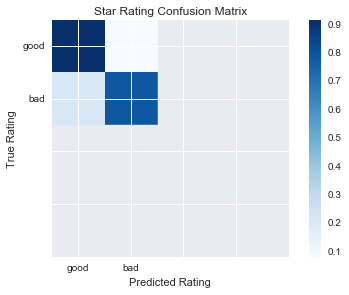

In [9]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, cls, title='Normalized confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, cls, rotation=0)
    plt.yticks(tick_marks, cls)
    plt.tight_layout()
    plt.ylabel('True Rating')
    plt.xlabel('Predicted Rating')

#classes = [1,2,3,4,5]
classes = ['good','bad']
cm = confusion_matrix(y_test,y_pred, labels=classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure()
plot_confusion_matrix(cm_normalized, classes, title='Star Rating Confusion Matrix')

plt.show()